In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'
import warnings

import torch

torch.manual_seed(0)
warnings.filterwarnings("ignore")

!rm -rf lightning_logs

# A simple energy model:

`graph-pes` aims to make getting set up with a new project as simple as possible. Below, we train a simple `LennardJones` for copper.

## 1: Data

`GraphPESModels` act on structures represented as `AtomicGraphs`. We expose several functions to make loading this data as simple as possible.

First, we load some chemical data. Here we use the wonderful [load-atoms](https://jla-gardner.github.io/load-atoms/) package to load a dataset of `ase.Atoms` objects:


In [2]:
from load_atoms import dataset

structures = dataset("Cu-POET")
structures

Please cite this dataset if you use it in your work.
For more information, visit:
https://jla-gardner.github.io/load-atoms/datasets/Cu-POET.html


Cu-POET:
    structures: 163
    atoms: 5,051
    species:
        Cu: 100.00%
    properties:
        per atom: (forces)
        per structure: (stress, config_type, energy)

We can see that this dataset has 163 structures, for a total of 5,051 atoms. Conveniently, we can see that the structures are labelled with per-structure energies (together with forces and stresses, which we will ignore for now).
Inspecting the first structure in this dataset gives:


In [3]:
structures[0]

Atoms(symbols='Cu8', pbc=True, cell=[2.5674848, 2.5674848, 25.41680279], forces=..., calculator=SinglePointCalculator(...))

Once we have a dataset of `ase.Atoms` objects, we can convert them to `AtomicGraphs` using the `convert_to_atomic_graphs` function. Using a cutoff of 5.0 Å, we can see that the first structure has 292 edges:


In [4]:
from graph_pes.data import convert_to_atomic_graphs

graphs = convert_to_atomic_graphs(structures, cutoff=5.0)
graphs[0]

AtomicGraph(Z=[8], positions=[8,3], neighbour_index=[2,292], forces=[8,3], energy=-28.79, stress=[3,3], device=cpu)

## 2: Model

Orthogonal to our data setup, we also need to define a model. Here we choose the simple `LennardJones` pair potential. Many others are available.


In [5]:
from graph_pes.models.pairwise import LennardJones

model = LennardJones()
model

LennardJones(
  (epsilon): PositiveParameter(0.1000)
  (sigma): PositiveParameter(1.0000)
)

## 3: Training

Now we can train the model on our data. Since `GraphPESModel`'s are just normal `torch.nn.Module`'s, we can standard PyTorch training setups.

For convenience, `graph-pes` exposes a `train_model` function that takes care of much of the boilerplate, and uses `pytorch-lightning` under-the-hood to make the analysis of training runs easy.


In [6]:
import torch
from graph_pes.data import random_split
from graph_pes.training import train_model
from graph_pes.util import Keys

# define a train/val/test split
train, val, test = random_split(graphs, [120, 20, 23], seed=42)


def optimizer():
    # use a high learning rate for such a simple model
    return torch.optim.Adam(model.parameters(), lr=0.03)


train_model(
    model,
    train,
    val,
    optimizer,
    # only train the model on the energy property
    property_labels={Keys.ENERGY: "energy"},
    batch_size=32,
    # the arguments below are passed to the PyTorch Lightning Trainer:
    max_epochs=150,
    accelerator="cpu",
)

Training on : ['energy']
# of params : 3
Device      : CPU

Epoch 149: 100%|██████████| 4/4 [00:00<00:00, 44.86it/s, v_num=0, val_energy_rmse=0.177, val_energy_raw_rmse=0.538, val_total_loss=0.177]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 4/4 [00:00<00:00, 42.87it/s, v_num=0, val_energy_rmse=0.177, val_energy_raw_rmse=0.538, val_total_loss=0.177]


LennardJones(
  (epsilon): PositiveParameter(0.1404)
  (sigma): PositiveParameter(2.2697)
)

## 4: Analysis

How did our model do? We can plot a naïve parity plot to see:

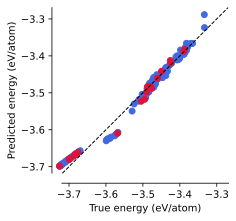

In [7]:
import matplotlib.pyplot as plt
from graph_pes.data import AtomicGraphBatch

plt.rcParams.update(
    {
        "figure.figsize": (3, 3),
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

# for convenience, we create batches of both the training and test data
train_batch = AtomicGraphBatch.from_graphs(train)
test_batch = AtomicGraphBatch.from_graphs(test)


def move_axes():
    for dir in ["left", "bottom"]:
        plt.gca().spines[dir].set_position(("outward", 10))


with torch.no_grad():
    train_predictions = model(train_batch)
    test_predictions = model(test_batch)

# scatter plot of true vs predicted energies
plt.scatter(
    train_batch["energy"] / train_batch.structure_sizes,
    train_predictions / train_batch.structure_sizes,
    c="royalblue",
    clip_on=False,
)
plt.scatter(
    test_batch["energy"] / test_batch.structure_sizes,
    test_predictions / test_batch.structure_sizes,
    c="crimson",
    clip_on=False,
)
plt.axline((-3.4, -3.4), slope=1, color="black", ls="--", lw=1)

# label axes
plt.xlabel("True energy (eV/atom)")
plt.ylabel("Predicted energy (eV/atom)")

# aesthetics
plt.gca().set_aspect("equal", "datalim")
plt.xlim(plt.ylim())
plt.yticks([-3.3, -3.4, -3.5, -3.6, -3.7])
plt.xticks([-3.3, -3.4, -3.5, -3.6, -3.7])
move_axes()

And that's a wrap! We've trained a simple model on a simple dataset. See other examples for more advanced use-cases.
